# RandomForest

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0


|Column title|	Description	|Range*	|Datatype|
|------------|--------------|-------|--------|
|__year__| The year
|__month__| number for month of the year
|__day__| number for day of the year
|__week__| day of the week as a character string
|__temp_2__| max temperature 2 days prior
|__temp_1__| max temperature 1 day prior
|__average__| historical average max temperature
|__actual__| max temperature measurement
|__friend__| Benchmark model, a random number between 20 below the average and 20 above the average

## Machine learning workflow
- State the question and determine required data
- Acquire the data in an accessible format
- Identify and correct missing data points/anomalies as required
- Prepare the data for the machine learning model
- Establish a baseline model that you aim to exceed
- Train the model on the training data
- Make predictions on the test data
- Compare predictions to the known test set targets and calculate performance metrics
- If performance is not satisfactory, adjust the model, acquire more data, or try a different modeling technique
- Interpret model and report results visually and numerically

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import datetime

def plot_temperature_actual_vs_prediction(features, test_features):

    # Realised
    months = features['month']
    days = features['day']
    years = features['year']
    dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
    true_data = pd.DataFrame(data = {'date': dates, 'temp': labels})

    # Prediction
    months = test_features['month']
    days = test_features['day']
    years = test_features['year']
    test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
    test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
    #predictions_data = pd.DataFrame(data = {'date': test_dates, 'temp': forest_preds})
    predictions_data = pd.DataFrame(data={'date': test_dates, 'temp': forest_preds})

    fig = plt.figure(figsize=(12, 10))
    plt.plot(true_data['date'], true_data['temp'], 'b-', label='Actual')
    plt.plot(predictions_data['date'], predictions_data['temp'], 'ro', label='Prediction')
    plt.xticks(rotation='60'); 
    plt.legend()
    plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


In [3]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    print('\nForest RMSE = {:.3f} ± {:.3f} F'.format(scores.mean(), scores.std()))

In [4]:
def summarise_cv_scores(grid_search):
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

# Get the Data

In [5]:
features = pd.read_csv('temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
year              348 non-null int64
month             348 non-null int64
day               348 non-null int64
week              348 non-null object
temp_2            348 non-null int64
temp_1            348 non-null int64
average           348 non-null float64
actual            348 non-null int64
forecast_noaa     348 non-null int64
forecast_acc      348 non-null int64
forecast_under    348 non-null int64
friend            348 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 32.7+ KB


In [7]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [8]:
features.groupby('month')['temp_1'].count()

month
1     31
2     26
3     31
4     30
5     31
6     30
7     31
8     19
9     28
10    30
11    30
12    31
Name: temp_1, dtype: int64

Missing dates in August and September

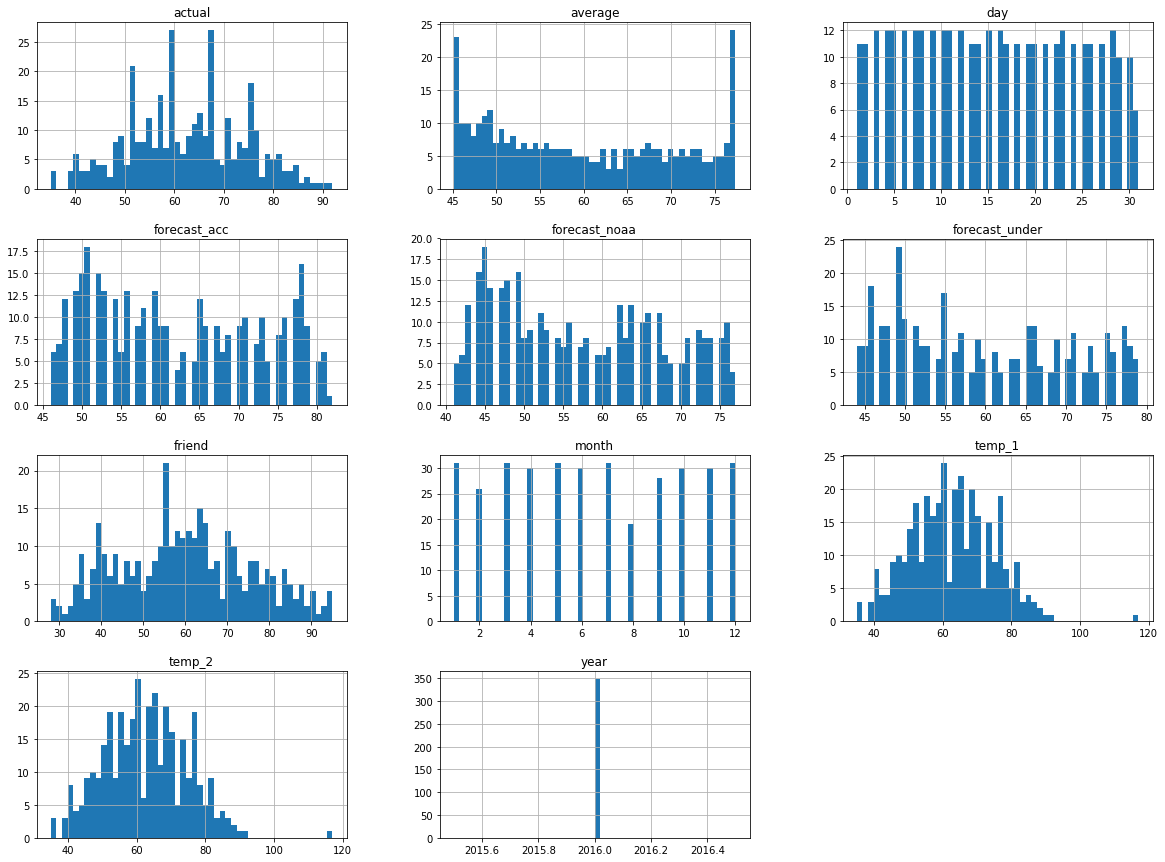

In [9]:
features.hist(bins=50, figsize=(20,15));

## One-hot encoding
Use pandas get_dummies method to automatically one-hot encode all variables.

In [124]:
features = pd.get_dummies(features)

In [125]:
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0


## Test and training sets

In [126]:
# Labels are the values we want to predict
labels = features['actual']
# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('actual', axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

In [127]:
features.head(5)

,year,month,day,temp_2,temp_1,average,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,46,46,46,41,0,0,0,0,0,1,0


In [128]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)

In [129]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


## Measure baseline model performance

In [130]:
baseline_preds = test_features['average']

In [131]:
from sklearn.metrics import mean_squared_error
baseline_mse = mean_squared_error(test_labels, baseline_preds)
baseline_rmse = np.sqrt(baseline_mse)
print('Baseline RMSE = {:.3f} F'.format(baseline_rmse))

Baseline RMSE = 7.382 F


## Basic RandomForest model

### Train

In [132]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=1000, random_state=42)
forest_reg.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### Measure performance

#### Root mean square

In [133]:
forest_preds = forest_reg.predict(test_features)
forest_mse = mean_squared_error(test_labels, forest_preds)
forest_rmse = np.sqrt(forest_mse)
print('Forest RMSE = {:.3f} F'.format(forest_rmse))

Forest RMSE = 5.102 F


In [134]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, test_features, test_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

scores = cross_val_score(forest_reg, test_features, test_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [135]:
display_scores(tree_rmse_scores)

Scores: [4.16332888 7.47226586 2.79858617 4.21330436 6.09798895 4.46046221
 4.87784949 5.00445675 1.7085627  5.6473963 ]
Mean: 4.644420167678575
Standard deviation: 1.5419845200997249

Forest RMSE = 4.644 ± 1.542 F


#### Mean absolute percentage error

In [136]:
errors = abs(forest_preds - test_labels)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


### Feature importance

In [137]:
importances = list(forest_reg.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]; 

Variable: temp_1               Importance: 0.66
Variable: average              Importance: 0.15
Variable: forecast_noaa        Importance: 0.05
Variable: forecast_acc         Importance: 0.03
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


Above shows: 
- temp_1 and average are the best parameters.
- that the weekday parameter is not even used.
- year is also useless as it is the same for all data

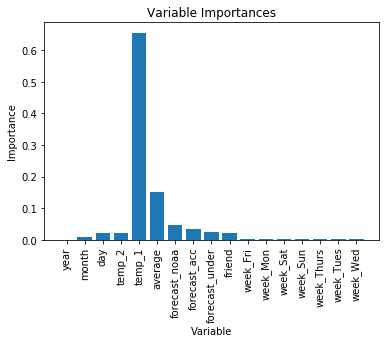

In [138]:
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Realised vs prediction

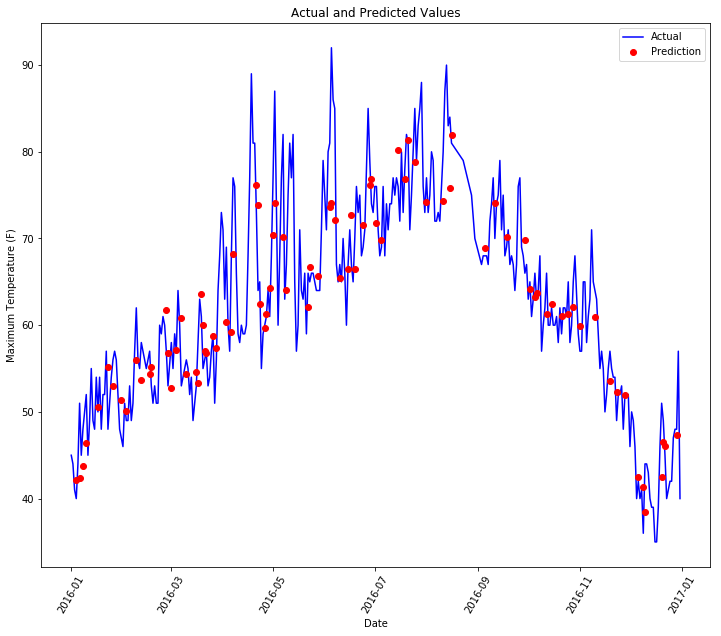

In [139]:
plot_temperature_actual_vs_prediction(features, test_features)

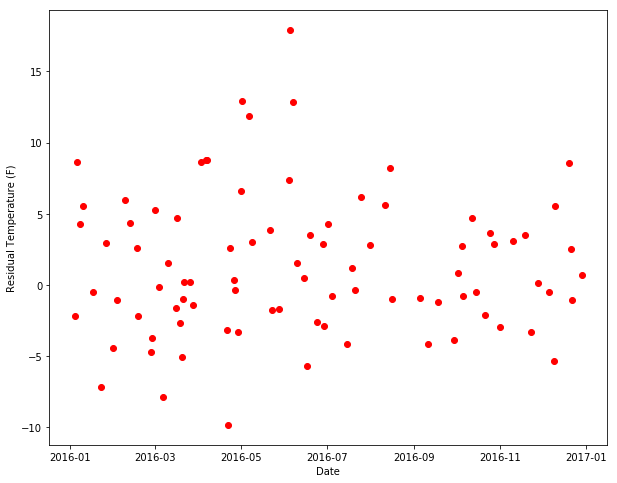

In [140]:
months = features['month']
days = features['day']
years = features['year']
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
true_data = pd.DataFrame(data = {'date': dates, 'temp': labels})

months = test_features['month']
days = test_features['day']
years = test_features['year']
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
predictions_data = pd.DataFrame(data={'date': test_dates, 'temp': forest_preds})

residuals = [true_data[true_data['date'] == date]['temp'].values[0] - 
             predictions_data[predictions_data['date'] == date]['temp'].values[0]   
             for date in test_dates]

fig = plt.figure(figsize=(10, 8))
plt.plot(predictions_data['date'], residuals, 'ro')
plt.xlabel('Date'); plt.ylabel('Residual Temperature (F)');

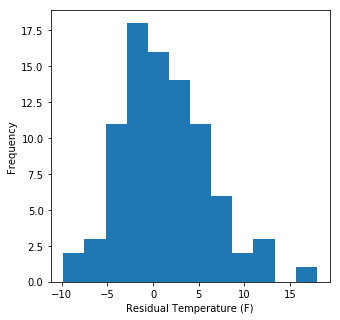

In [141]:
fig = plt.figure(figsize=(5, 5))
plt.hist(residuals, bins=12)
plt.xlabel('Residual Temperature (F)'); plt.ylabel('Frequency');

## Improved RandomForest model

### Clean data

In [157]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = pd.read_csv('temps.csv')

# Scaling is not important for Random Forests as it only works on thresholds
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

# Labels are the values we want to predict
labels = features['actual']
# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('actual', axis=1)

features = features.drop('friend', axis=1)
features = features.drop('week', axis=1)
# Remove the challenger forecasts
features = features.drop('forecast_noaa', axis=1)
features = features.drop('forecast_acc', axis=1)
features = features.drop('forecast_under', axis=1)
# Year does not change in the current dataset
#features = features.drop('year', axis=1)

# Saving feature names for later use
feature_list = list(features.columns)

#X_train = num_pipeline.fit_transform(features)
X_train = np.array(features)

In [158]:
features.head(5)

,year,month,day,temp_2,temp_1,average
0,2016,1,1,45,45,45.6
1,2016,1,2,44,45,45.7
2,2016,1,3,45,44,45.8
3,2016,1,4,44,41,45.9
4,2016,1,5,41,40,46.0


### Train

In [159]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X_train, labels, test_size=0.25, random_state=42)

In [177]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=1000, random_state=42)
forest_reg.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### Measure performance

#### Root mean square

In [161]:
forest_preds = forest_reg.predict(test_features)
forest_mse = mean_squared_error(test_labels, forest_preds)
forest_rmse = np.sqrt(forest_mse)
print('Forest RMSE = {:.3f} F'.format(forest_rmse))

Forest RMSE = 4.939 F


In [162]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, test_features, test_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

scores = cross_val_score(forest_reg, test_features, test_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [163]:
display_scores(tree_rmse_scores)

Scores: [4.14575925 6.56455029 3.14847919 4.33934687 6.35628637 3.28182084
 4.18637074 5.06067329 1.75058497 5.62799948]
Mean: 4.446187129443546
Standard deviation: 1.4277764993838444

Forest RMSE = 4.446 ± 1.428 F


#### Mean absolute percentage error

In [164]:
errors = abs(forest_preds - test_labels)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 94.03 %.


### Feature importance

In [165]:
feature_list

['year', 'month', 'day', 'temp_2', 'temp_1', 'average']

In [170]:
importances = list(forest_reg.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, forest_reg.feature_importances_)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]; 

Variable: temp_1               Importance: 0.7
Variable: average              Importance: 0.21
Variable: day                  Importance: 0.04
Variable: temp_2               Importance: 0.03
Variable: month                Importance: 0.02
Variable: year                 Importance: 0.0


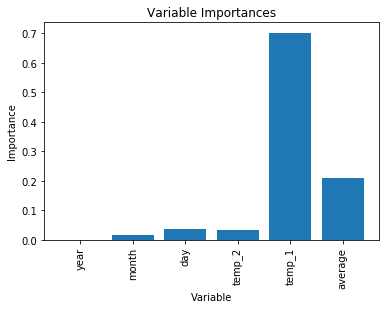

In [171]:
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Realised vs prediction

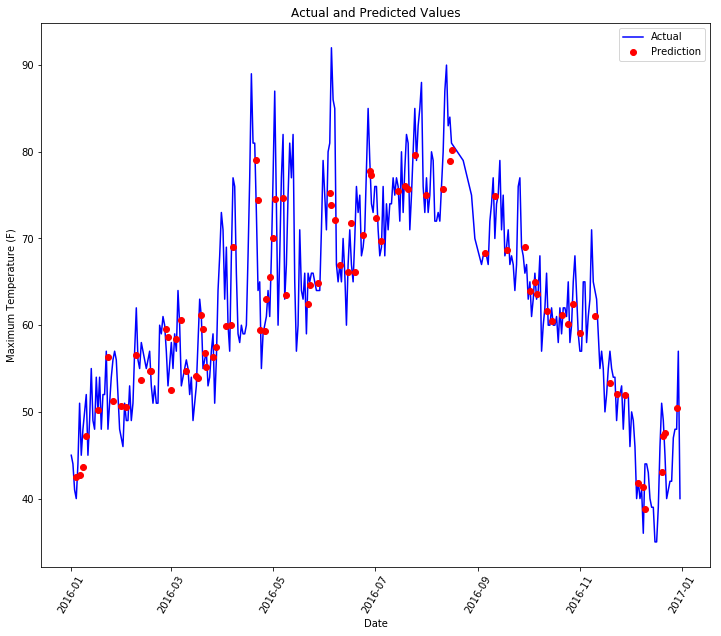

In [168]:
#plot_temperature_actual_vs_prediction(features, test_features)
# Realised
months = features['month']
days = features['day']
years = features['year']
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
true_data = pd.DataFrame(data = {'date': dates, 'temp': labels})

# Prediction
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
#predictions_data = pd.DataFrame(data = {'date': test_dates, 'temp': forest_preds})
predictions_data = pd.DataFrame(data={'date': test_dates, 'temp': forest_preds})

fig = plt.figure(figsize=(12, 10))
plt.plot(true_data['date'], true_data['temp'], 'b-', label='Actual')
plt.plot(predictions_data['date'], predictions_data['temp'], 'ro', label='Prediction')
plt.xticks(rotation='60'); 
plt.legend()
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


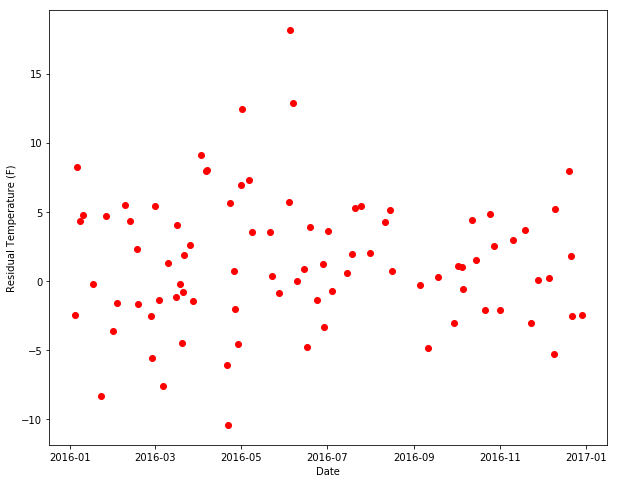

In [169]:
months = features['month']
days = features['day']
years = features['year']
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
true_data = pd.DataFrame(data = {'date': dates, 'temp': labels})

months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
predictions_data = pd.DataFrame(data={'date': test_dates, 'temp': forest_preds})

residuals = [true_data[true_data['date'] == date]['temp'].values[0] - 
             predictions_data[predictions_data['date'] == date]['temp'].values[0]   
             for date in test_dates]

fig = plt.figure(figsize=(10, 8))
plt.plot(predictions_data['date'], residuals, 'ro')
plt.xlabel('Date'); plt.ylabel('Residual Temperature (F)');

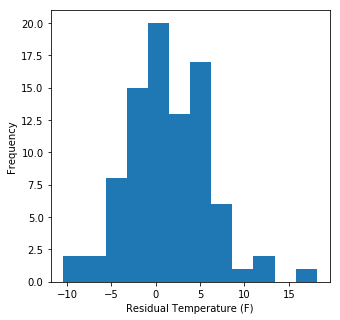

In [204]:
fig = plt.figure(figsize=(5, 5))
plt.hist(residuals, bins=12)
plt.xlabel('Residual Temperature (F)'); plt.ylabel('Frequency');

## Optimising hyperparameters

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Some RandomForest parameters:
- __n_estimators__: The number of trees in the forest.
- __max_features__: The number of features to consider when looking for the best split.
- __max_depth__: The maximum depth of the tree.


### GridSearchCV

In [180]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
              ]
forest_reg = RandomForestRegressor()
n_jobs=6
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=n_jobs)
#grid_search.fit(X_train, labels)
grid_search.fit(train_features, train_labels)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [181]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [185]:
summarise_cv_scores(grid_search)

5.351103855597734 {'max_features': 2, 'n_estimators': 3}
5.325320849075093 {'max_features': 2, 'n_estimators': 10}
5.095147266811636 {'max_features': 2, 'n_estimators': 30}
5.750043959333694 {'max_features': 4, 'n_estimators': 3}
5.257007729516785 {'max_features': 4, 'n_estimators': 10}
5.168342331164537 {'max_features': 4, 'n_estimators': 30}
5.805635758121695 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
5.545447893287318 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
5.5907696233025845 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
5.460825306381804 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
6.043372397605747 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
5.628716737168401 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


Above shows bootstrap on is best and n_estimators >= 30 are best. Try again by refining the search range.

#### Second search

In [193]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators': [25, 30, 35], 'max_features': [2, 3]},
              ]
forest_reg = RandomForestRegressor()
n_jobs=6
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=n_jobs)
#grid_search.fit(X_train, labels)
grid_search.fit(train_features, train_labels)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid=[{'n_estimators': [25, 30, 35], 'max_features': [2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [194]:
summarise_cv_scores(grid_search)

5.09662648548695 {'max_features': 2, 'n_estimators': 25}
4.998353827682499 {'max_features': 2, 'n_estimators': 30}
4.938963445772819 {'max_features': 2, 'n_estimators': 35}
5.1352055102190315 {'max_features': 3, 'n_estimators': 25}
4.994976190480322 {'max_features': 3, 'n_estimators': 30}
5.0634859208662615 {'max_features': 3, 'n_estimators': 35}


### Optimised model and parameters

In [195]:
forest_reg = RandomForestRegressor()
forest_reg.fit(train_features, train_labels)

C:\Users\Mark\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [199]:
forest_preds = forest_reg.predict(test_features)
forest_mse = mean_squared_error(test_labels, forest_preds)
forest_rmse = np.sqrt(forest_mse)
print('Forest RMSE = {:.3f} F'.format(forest_rmse))

Forest RMSE = 5.380 F


In [196]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, test_features, test_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

scores = cross_val_score(forest_reg, test_features, test_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [197]:
display_scores(tree_rmse_scores)

Scores: [4.49765371 6.39270417 2.77628849 5.45262424 6.28446055 2.50532766
 4.80636153 5.30683522 1.61090037 5.5215487 ]
Mean: 4.51547046297294
Standard deviation: 1.5734335590312079

Forest RMSE = 4.515 ± 1.573 F


In [200]:
errors = abs(forest_preds - test_labels)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.62 %.


## PCA

In [203]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_features)

for pairs in zip(pca.components_[0], features.columns):
    print(pairs)

(-0.0, 'year')
(-0.007801549956103493, 'month')
(0.0038796910567268916, 'day')
(-0.5937718759777391, 'temp_2')
(-0.6167083303697675, 'temp_1')
(-0.5167493380411795, 'average')
